# Tutorial 1 - Spike Encoding

## Learn how to
- convert datasets into spiking datasets
- how to visualize them
- how to generate random spike trains

> MNIST 데이터셋을 SNN으로 학습하기 위한 spiking dataset으로 변환하고 사용하는 방법에 대해 공부한다.

---

# 1. Setting up the MNIST dataset

In [1]:
import snntorch as snn
import torch

# Traning params
batch_size  = 128
data_path   = './data'
num_classes = 10    # MNIST 0~9

# Torch variables
dtype = torch.float

In [2]:
# Download Dataset
from torchvision import datasets, transforms

# Define a transform
transforms = transforms.Compose([
             transforms.Resize((28,28)),
             transforms.Grayscale(),
             transforms.ToTensor(),
             transforms.Normalize((0,), (1,))
             ])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transforms)

MNIST 데이터셋은 60,000장의 이미지를 가지고 있다. 빠른 구현을 위해 서브셋으로 전체 데이터의 1/10인 6,000장의 데이터셋을 생성해준다.

snntorch.utils는 서브셋을 생성해주는 함수를 포함한다.

In [3]:
from snntorch import utils

subset_size = 10
mnist_train = utils.data_subset(mnist_train, subset_size)

print(f'The size of mnist_train is {len(mnist_train)}')

The size of mnist_train is 6000


위에서 가져온 데이터셋은 메모리에 저장된다. PyTorch의 DataLoader는 이 데이터셋을 배치 단위로 네트워크에 제공해준다.

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# 2. Spike Encoding

SNN의 입력으로 데이터를 제공하기 위해 두 가지 방식을 고려할 수 있다. 하나는 동일한 이미지를 매 시간(time step)마다 제공하는 것이고, 다른 하나는 시간에 의존하는(time-varying) spikes(sequence)로 변환하여 제공하는 것이다. 두 번째 방식이 SNN에 더 적합하므로 해당 방식에 대해 알아보겠다.

![122spikeinput](images/1_2_2_spikeinput.png)

모듈 snntorch.spikegen (i.e., spike generation)은 데이터를 spike sequence로 변환해주는 함수를 내포하고 있다. 이를 사용하여 엔코딩을 수행할 수 있는데 여기에는 세 가지 방식이 존재한다.

> 1. Rate coding: spikegen.rate
>
> 2. Latency coding: spkiegen.latency
>
> 3. Delta modulation: spikegen.delta

## 2.1 Rate coding

Rate coding 방식은 spiking frequency에 따라 데이터 신호를 생성한다. 이는 *베르누이 시행(Bernoulli trial)* 을 따른다. 간단히 말해 각 픽셀마다 ON/OFF 두 가지로 상태를 구분하는 것이다. 입력 feature를 $X_{ij}$, rate-coded의 출력을 $R_{ij}$ 라 하면 아래와 같이 표현할 수 있다.

> $R_{ij}$ ~ $B(n, p)$

여기서 $n$은 총 시행 갯수이고, $p$는 $n$번 시행에 대해 성공할(여기서는 spiking) 확률이다. 만일 $n$이 1이라면 $p$는 $1=X_{ij}$, 즉 원본 이미지 그 자체가 될 것이다.

> $P(R_{ij}=1)=X_{ij}=1-P(R_{ij}=0)$

아래 코드에서는 모든 요소가 0.5인 벡터를 생성하여, torch.bernoulli()의 입력으로 하였다. torch.bernoulli() 함수의 출력에 대해 설명하자면, 입력 벡터의 각 요소는 (어떤 것이 )성공할 확률이 된다. 그리고 각 인덱스마다 주어진 확률에 따라 성공(1)과 실패(0)가 결정되어 출력된다. 입력 벡터의 모든 값이 0.5 였으므로, 모든 요소가 50%의 확률로 성공하여 대략 절반의 1, 절반의 0으로 구성된 벡터가 출력될 것이다.

num_step(==time step)이 커질 수록(무한대에 수렴할 수록) spiking의 성공 확률은 raw_vect의 값과 비슷할 것이다.

In [5]:
# Temporal dynamics
num_steps = 100       # == time step

# Create vector filled with 0.5
raw_vect = torch.ones(num_steps) * 0.5       # 각 index마다 spiking 에 성공할 확률
print(f'Raw vector: {raw_vect}')

# Pass each sample through a Bernoulli trial
rate_coded_vect = torch.bernoulli(raw_vect)
print(f'Converted vector: {rate_coded_vect}')

print(f'The output is spiking {rate_coded_vect.sum()*100/len(rate_coded_vect):.2f}% of the time.')

Raw vector: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])
Converted vector: tensor([0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1

MNIST 이미지에 위와 같이 베르누이 시행을 적용하여 rate coded 데이터로 변환하면 SNN의 입력으로 하고자 하는 spike sequence로 변환할 수 있다.

![123spikeconv](images/1_2_3_spikeconv.png)

In [6]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking data
spike_data = spikegen.rate(data_it, num_steps=num_steps)        # gain=1.0(default), gain의 값을 변경하여 spiking의 정도를 수정할 수 있다.
print(spike_data.size())        # num_steps x batch_size x input dimensions

torch.Size([100, 128, 1, 28, 28])


In [7]:
# Visualization

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


In [8]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)     # gain=1.0(default), gain의 값을 변경하여 spiking의 정도를 수정할 수 있다.

spike_data_sample2 = spike_data[:, 0, 0]

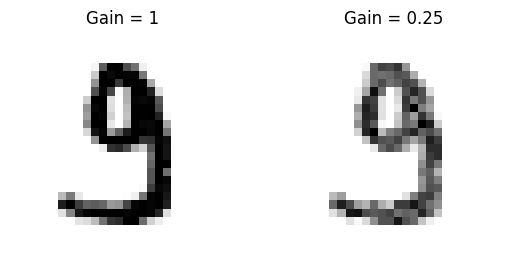

In [9]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

Raster plot으로 생성하여 보일 수도 있다. 이를 위해서는 2D 텐서로 reshape이 필요하다. 다음 그래프는 시간축에 대한 뉴런의 개수를 표현한 것이다.

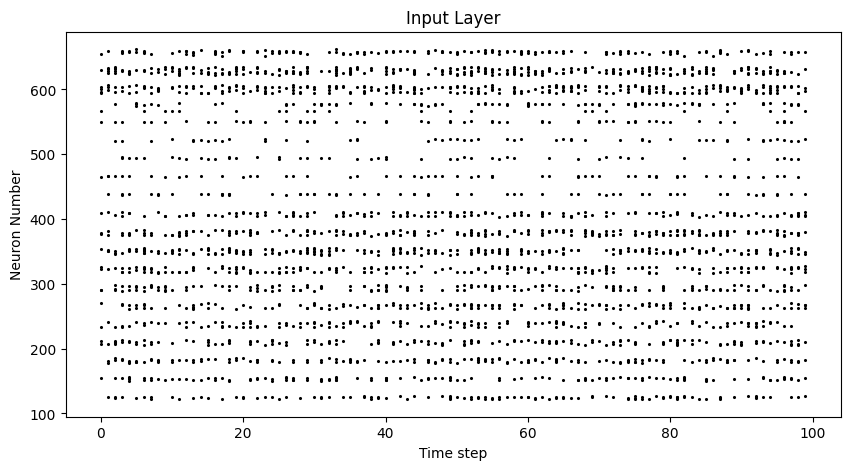

In [10]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

해당 방법은 소비 전력 문제와 반응 시간에 대한 이슈로 인해 많이 사용하는 방법론은 아니라고 한다.

## 2.2 Latency coding

Latency coding은 뉴런을 활성화 하는 시간에 따라 정보를 얻는다. 이 방법은 노이즈에 더 민감할 수 있지만, frequency 기반의 방법보다 SNN을 학습하는데 있어 더 적은 전력을 소비함에 있어 이점을 가진다.

해당 내용은 current source RC 회로로 이해할 수 있다. 간단히 아래 다이어그램을 간단히 설명하자면, 인풋이 크면 클 수록 반응 시간이 빠르다는 것이다.

![124](./images/1_2_4_latencyrc.png)

예시 코드를 통해 이를 확인할 수 있다.

In [11]:
def Convert2Time(data, tau=5, threshold=0.01):
    spike_time = tau * torch.log(data / (data - threshold))
    return spike_time

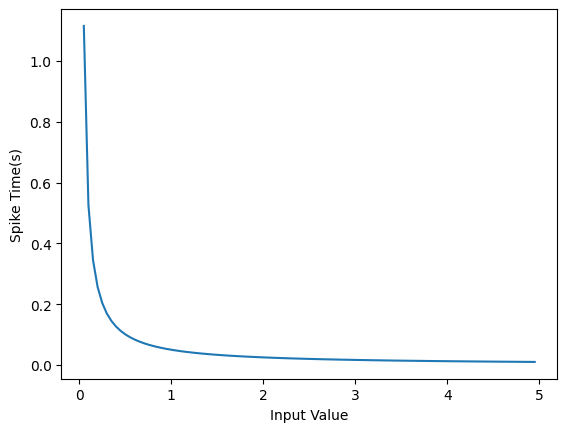

In [12]:
raw_input   = torch.arange(0, 5, 0.05)    # tensor from 0 to 5 with 0.05 interval
spike_times = Convert2Time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time(s)')
plt.show()

이제 주어진 mnist 데이터를 latency coding 하여 출력하면 아래와 같은 plot을 확인할 수 있다.

In [14]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

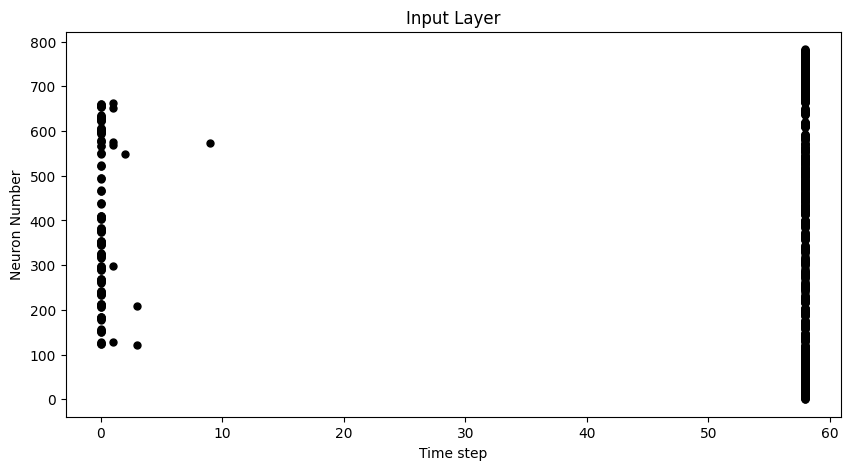

In [15]:
# Raster plot

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

위 플롯은 아래와 같이 해석하면 이해하기 편하다.

![125](./images/1_2_5_latencyraster.png)

위 결과는 spikegen.latency() 함수의 인자인 *linear, normalize, clip* 인자를 True로 설정하여 불필요한 정보들이나 데이터 분포를 보다 용이하게 바꿀 수 있다.

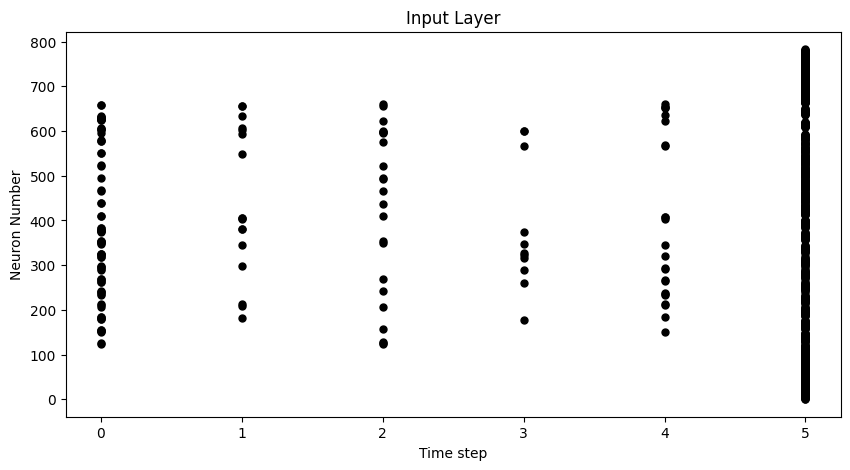

In [16]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

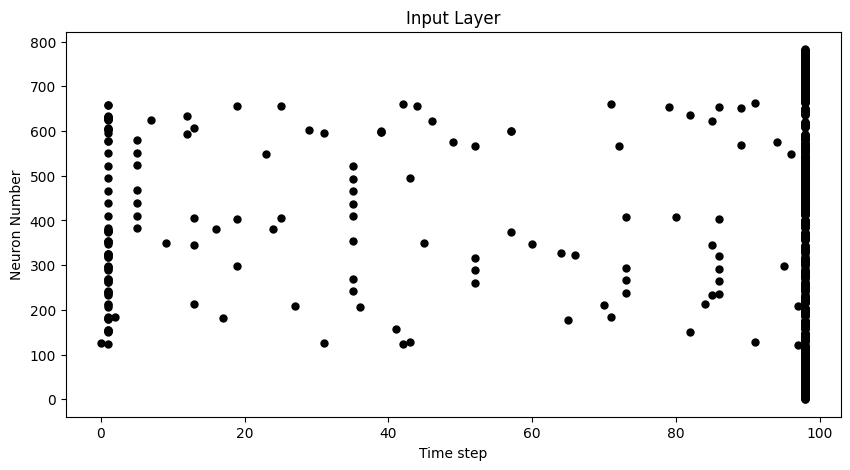

In [17]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

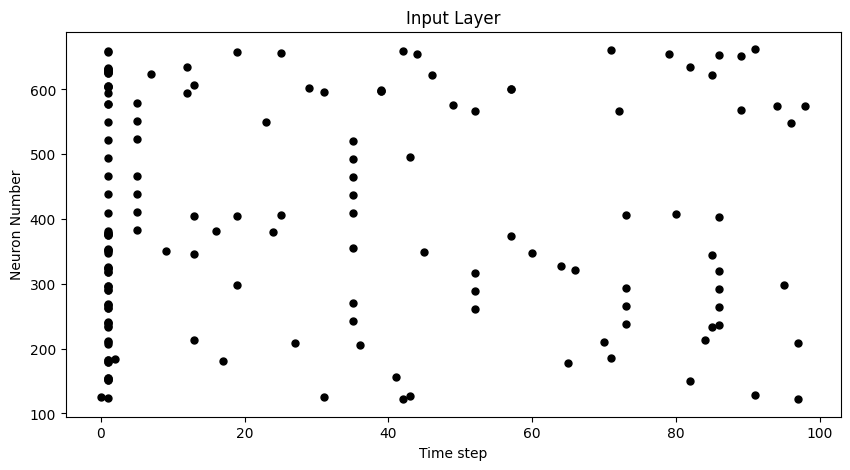

In [18]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

## 2.3 Delta Modulation

해당 방법론은 이벤트 카메라와 같은 센서 데이터를 처리하는데 사용된다는 듯 하다.